# nbeats simulation experiment trial 50

- 랜덤 시계열 생성 함수로 50개 TS 생성
- 각 TS마다 개별적으로 모형을 적합하여 예측결과를 확인
- 랜덤 시계열 생성 함수 : $y = \beta_{1i} cos(\frac{2\pi t_i}{period_{1i}}) + \beta_{2i} sin(\frac{2\pi t_i}{period_{2i}} ) + \beta_{3i} t_i + \epsilon_i$
    - $ \beta_{1i} \sim N(0, 0.5)$
    - $ \beta_{2i} \sim N(0, 0.5)$
    - $ \beta_{3i} \sim N(0, 0.03)$
    - $ \epsilon_{i} \sim N(0, 1)$
    - $ P(period = k) = \frac{1}{48},k = \{1,2,..47,48\}$
---

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [14]:
##############################################################################################################
def window(df, timestep):
    '''
    단변량 데이터를 timestep에 따라 window로 생성하는 함수
    
    '''
    for i in range(0, timestep):
        df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
        df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
    window_df = df.dropna(axis=0) # 결측치 공간 제거
    window_df = window_df.iloc[:,::-1] # 좌우 반전


    feature= window_df.iloc[:,:-1].values
    y_label= window_df.iloc[:,-1].values

    return feature

##############################################################################################################
def generate_time(t, 
                  cosine_period1=24,
                  sine_period1=24,
                  cosine_slope1=1,
                  sine_slope1=1,
                  trend_slope = 0,
                #  trend_intercept = 0,
                #  phase_shift=0, 
                  noise_level=0.1):
    '''
    cosin, sin, trend, 기울기 등을 결합하여 데이터 생성
    y = b1*cos(2*pi*t/period) + b2*cos(2*pi*t/period) + b3*t + epsilon
    '''

    series = (cosine_slope1 * np.cos(2 * np.pi / cosine_period1 * (t )) +
              sine_slope1 * np.sin(2 * np.pi / sine_period1 * (t )) + 
              trend_slope * t )


    # Add Gaussian noise
    noise = noise_level * np.random.randn(len(t))
    series += noise

    return series
##############################################################################################################

def random_parameters():
    '''
    랜덤 파라미터
    '''
    cosine_period = np.random.randint(1, 49)
    sine_period = np.random.randint(1, 49)# 1 to 48
    cosine_slope= np.random.normal(0,0.5) #np.random.uniform(0, 1)  
    sine_slope= np.random.normal(0,0.5) 
    trend_slope = np.random.normal(0,0.03) 
    noise_level = np.random.uniform(0, 1)  # 0 to 1
    return cosine_period,sine_period ,cosine_slope,sine_slope,trend_slope,noise_level
##############################################################################################################

def generate_random_ts(t):
    '''
    랜덤 파라미터에 의한 데이터 생성
    '''
    cosine_period,sine_period ,cosine_slope,sine_slope,trend_slope,noise_level = random_parameters()
    
    random_ts= generate_time(t, 
                  cosine_period1=cosine_period,
                  sine_period1=sine_period,
                  cosine_slope1=cosine_slope,
                  sine_slope1=sine_slope,
                  trend_slope = trend_slope,
                #  trend_intercept = 0,
                #  phase_shift=0, 
                  noise_level=noise_level)
    
    return random_ts
##############################################################################################################

def split_train_test(list_in_array, horizon, lookback):
    '''
    train_test 모형 적합 전처리 함수
    1. train, test 분리
    2. input, output 분리
    '''
    
    train = np.array([list_in_array[i][:-horizon*(lookback+1)] for i in range(len(list_in_array))])
    test = np.array([list_in_array[i][-horizon*(lookback+1):] for i in range(len(list_in_array))])
    
    
    window_train= [window(pd.DataFrame(train[i]),horizon*(lookback+1)) for i in range(len(train))]
    X_train = [window_train[i][:,:-horizon] for i in range(len(window_train))]
    y_train = [window_train[i][:,-horizon:] for i in range(len(window_train))]
    X_test = test[:,:-horizon]#.reshape(-1,1)
    y_test = test[:,-horizon:]#.reshape(-1,1)
    
    X_test = [X_test[i].reshape(1,-1) for i in range(len(X_test))]
    y_test = [y_test[i].reshape(1,-1) for i in range(len(y_test))]
    
    
    return X_train ,y_train, X_test,y_test

In [105]:
# 주기 24 데이터에 대한 랜덤 시계열 생성 후 모형 예측
horizon = 24
lookback = 3
# X_sequence = 24*3
np.random.seed(1)
t = np.arange(0,360)
random_ts= [generate_random_ts(t) for i in range(50)]
X_train ,y_train, X_test,y_test = split_train_test(random_ts,horizon,lookback )

In [60]:
X_train[0].shape ,y_train[0].shape, X_test[0].shape,y_test[0].shape

((169, 72), (169, 24), (1, 72), (1, 24))

---

## nbeats, lstm 모형적합

- nbeats
    - 스택 : 4개
    - 블락 : 4개
    - 각 레이어 당 unit = 128
- lstm
    - 단층
    - unit : 128
    - timedistributed
- 동일 옵션
    - 배치사이즈 : 2
    - 에포크 : 20
    - patience=5
    - Adam(learning_rate=0.001)

In [11]:
# nbeats 파라미터
input_dim, output_dim =  1, 1
backcast= horizon*lookback
forecast = horizon #7

(72, 24)

In [120]:
# lstm 모형생성
def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

In [119]:
TS_ID = 50
#######################################################################################################################################
nbeats_pred_score = []
nbeats_pred_lst = []
nbeats_pred_time = []



for i in range(TS_ID):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train[i],y_train[i],validation_data=(X_test[i],y_test[i]),
                        epochs=20, batch_size=2, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test[i])
    me1= mean_squared_error(y_test[i].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[i].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[i].flatten(),pred.flatten())
    
    nbeats_pred_lst.append(pred.flatten())
    nbeats_pred_score.append([me1,me2,me3])
    nbeats_pred_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_pred_score = []
lstm_pred_lst = []
lstm_pred_time = []

for i in range(TS_ID):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train[i], y_train[i],validation_data=(X_test[i],y_test[i]), 
                        epochs=20, batch_size=2, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test[i])
    me1= mean_squared_error(y_test[i].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[i].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[i].flatten(),pred.flatten())
    
    lstm_pred_lst.append(pred.flatten())
    lstm_pred_score.append([me1,me2,me3])
    lstm_pred_time.append(time2-time1)

1/1 [==============================] - 1s 1s/step
Epoch 19: early stopping
1/1 [==============================] - 0s 273ms/step
Epoch 11: early stopping
1/1 [==============================] - 0s 274ms/step
Epoch 9: early stopping
1/1 [==============================] - 0s 270ms/step
Epoch 19: early stopping
1/1 [==============================] - 0s 273ms/step
Epoch 10: early stopping
1/1 [==============================] - 0s 274ms/step
Epoch 18: early stopping
1/1 [==============================] - 0s 277ms/step
Epoch 17: early stopping
1/1 [==============================] - 0s 286ms/step
Epoch 20: early stopping
1/1 [==============================] - 0s 272ms/step
Epoch 19: early stopping
1/1 [==============================] - 0s 275ms/step


---
## lstm

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
np.expand_dims(y_train[0],axis=2).shape

(169, 24, 1)

In [74]:
backcast, horizon

(72, 24)

In [75]:
def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

In [106]:
lstm_pred_score = []
lstm_pred_lst = []
lstm_pred_time = []
TS_ID = 10

for i in range(10):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train[i], y_train[i],validation_data=(X_test[i],y_test[i]), 
                        epochs=20, batch_size=2, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test[i])
    me1= mean_squared_error(y_test[i].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[i].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[i].flatten(),pred.flatten())
    
    lstm_pred_lst.append(pred.flatten())
    lstm_pred_score.append([me1,me2,me3])
    lstm_pred_time.append(time2-time1)

Epoch 19: early stopping
1/1 [==============================] - 0s 270ms/step
Epoch 13: early stopping
1/1 [==============================] - 0s 276ms/step
Epoch 10: early stopping
1/1 [==============================] - 0s 273ms/step


---
## 결과

- 50개의 TS에 대한 nbeats와 lstm의 예측 결과를 나타낸 그래프

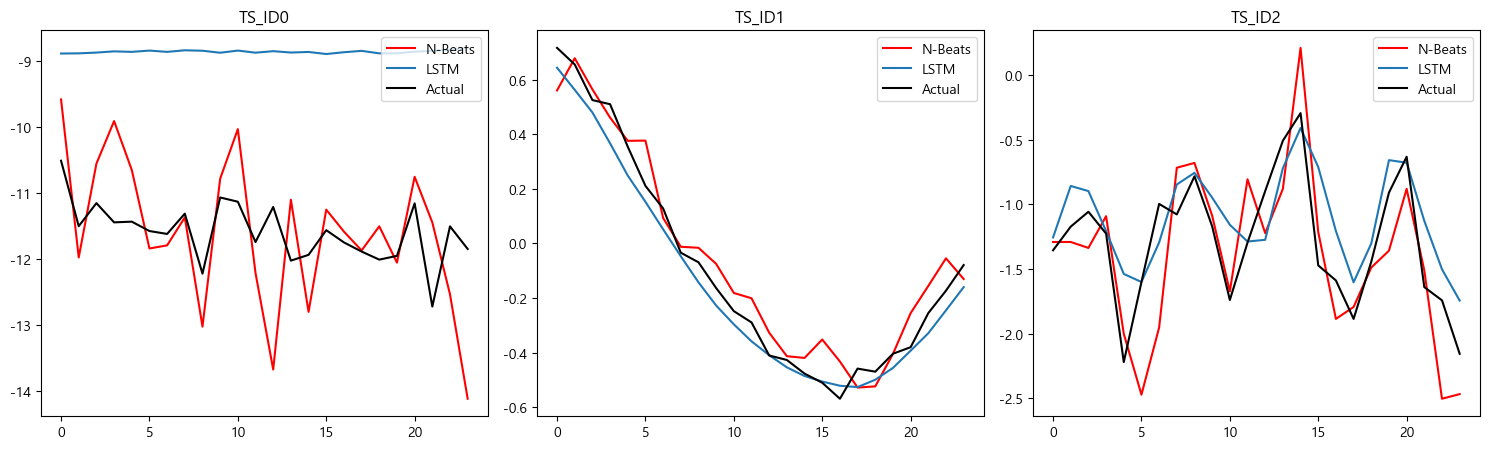

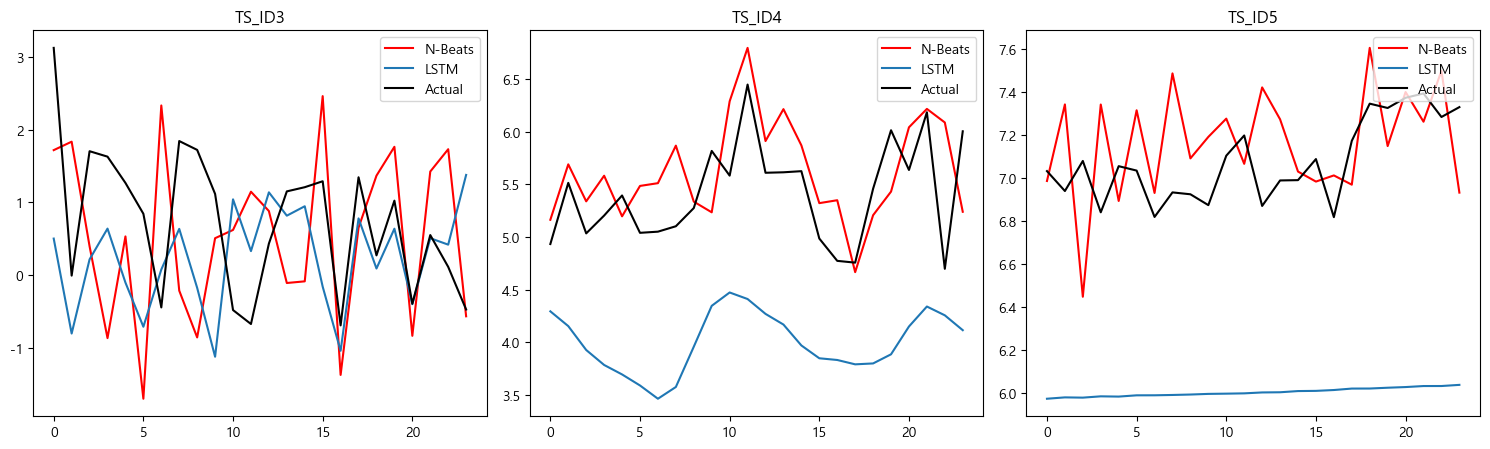

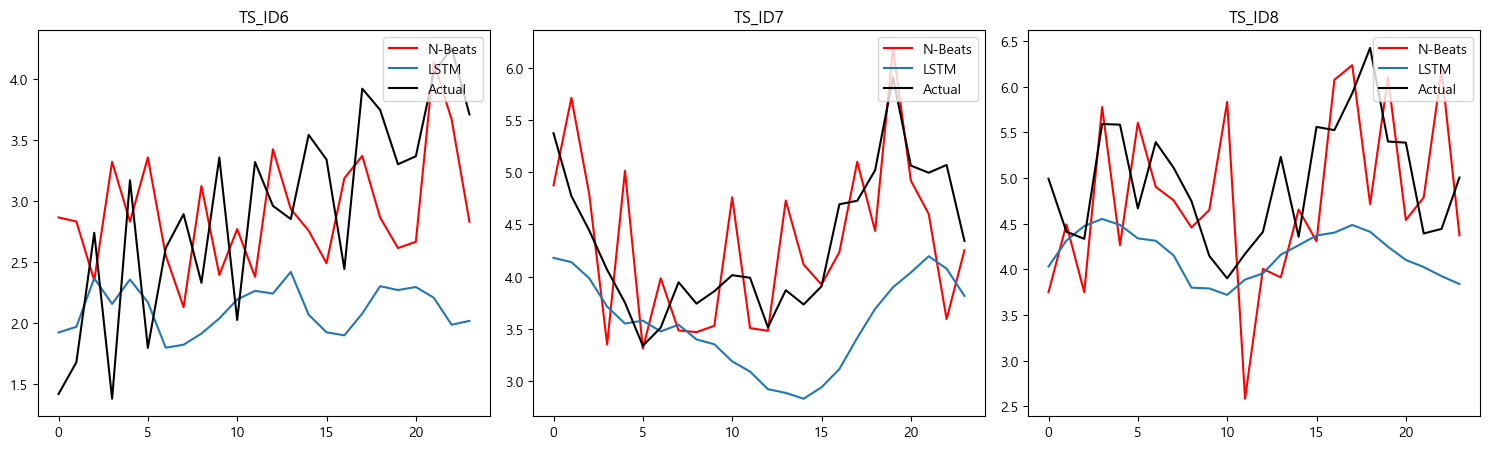

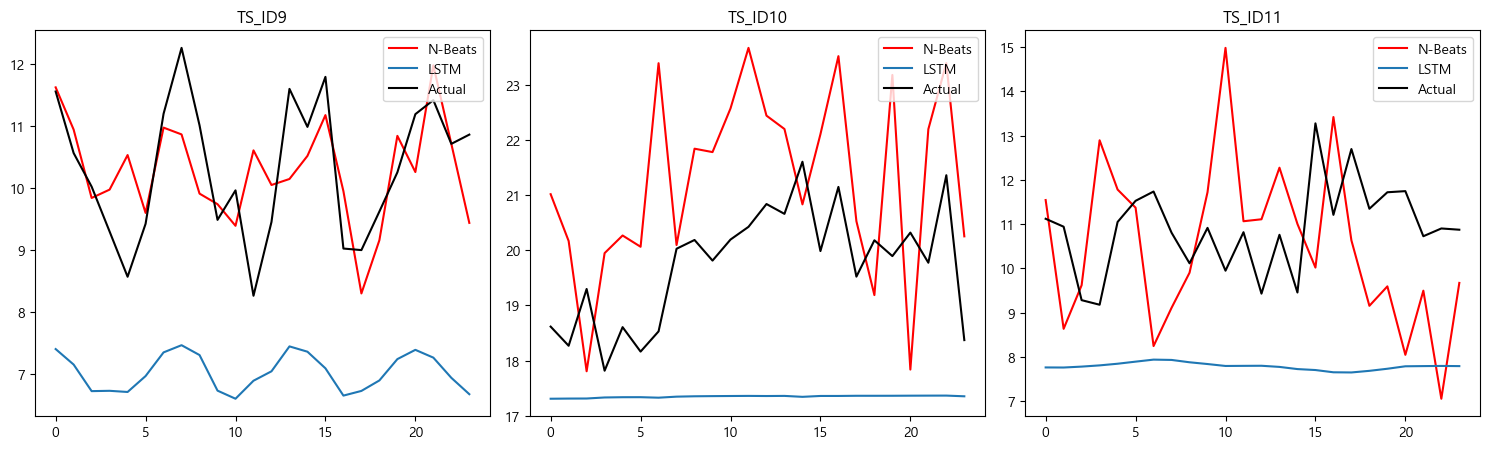

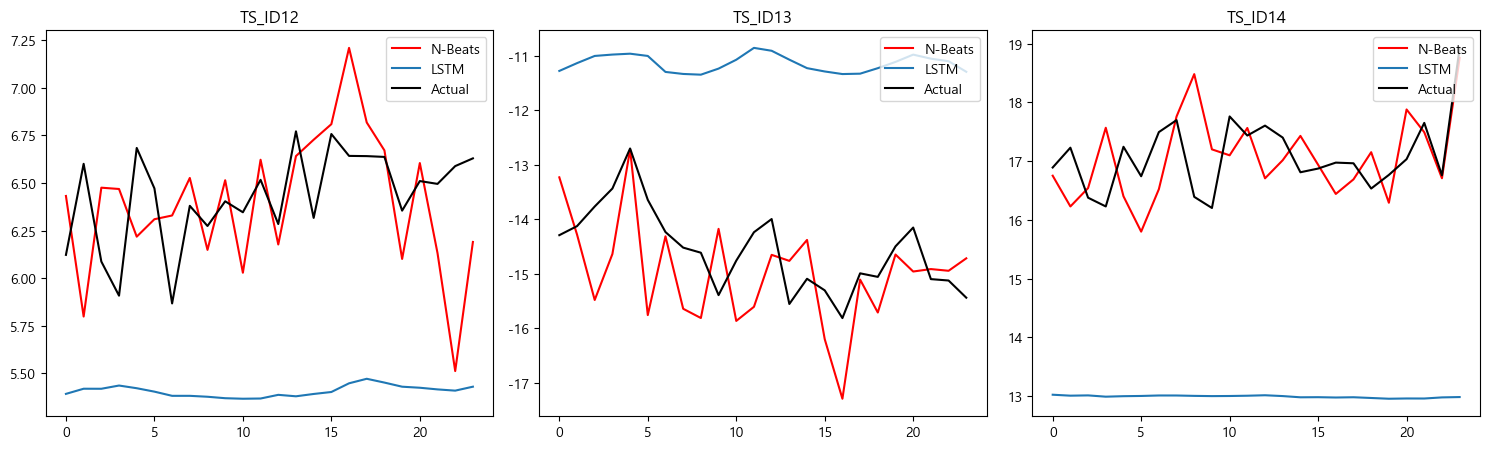

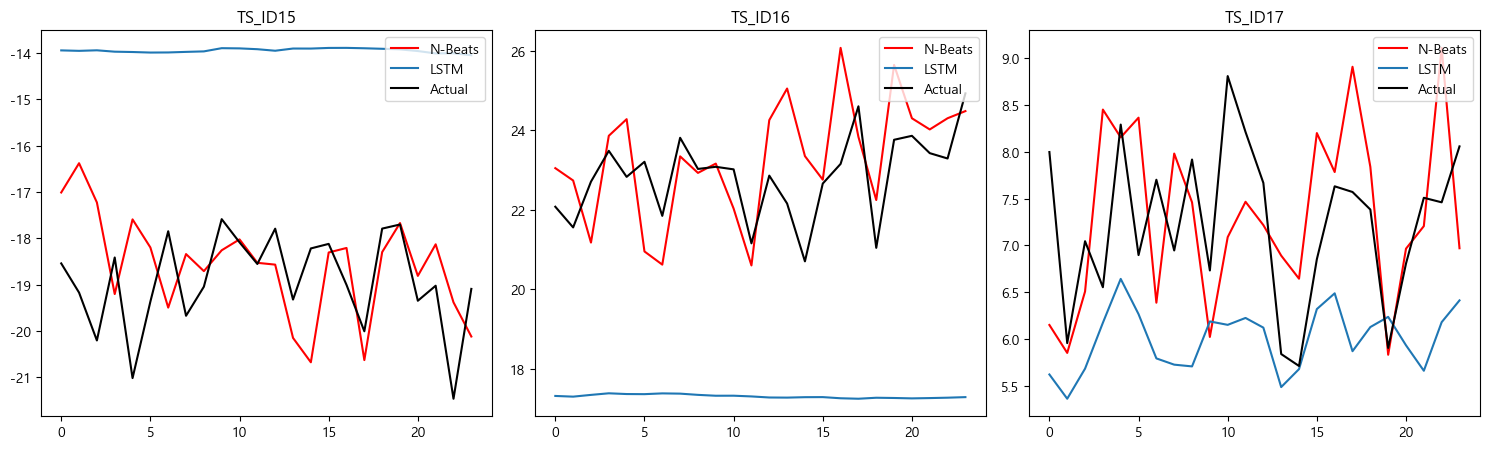

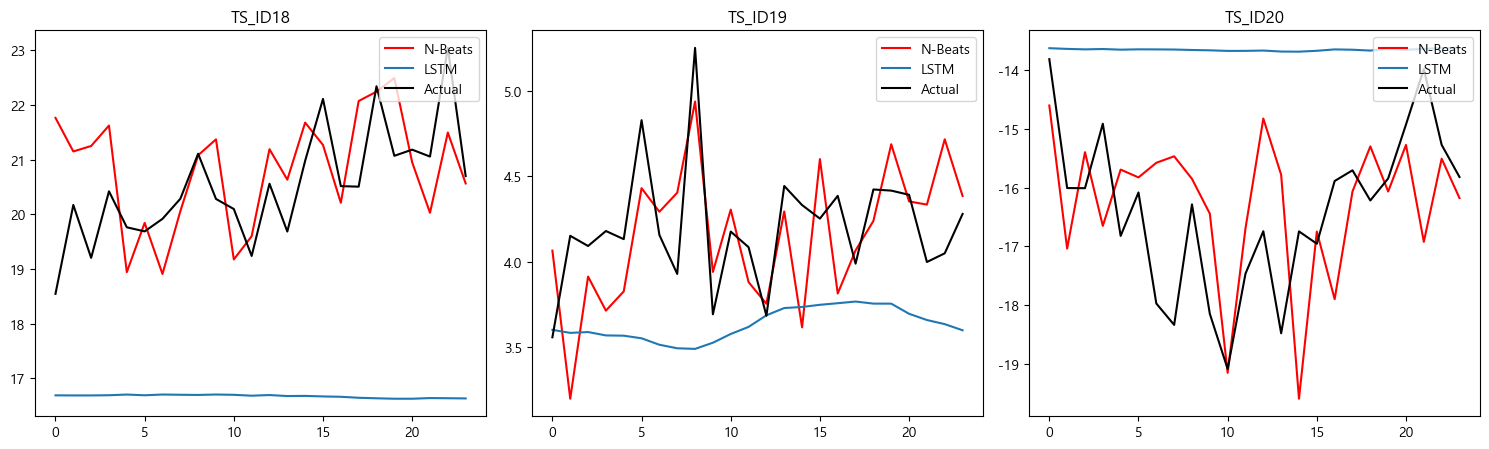

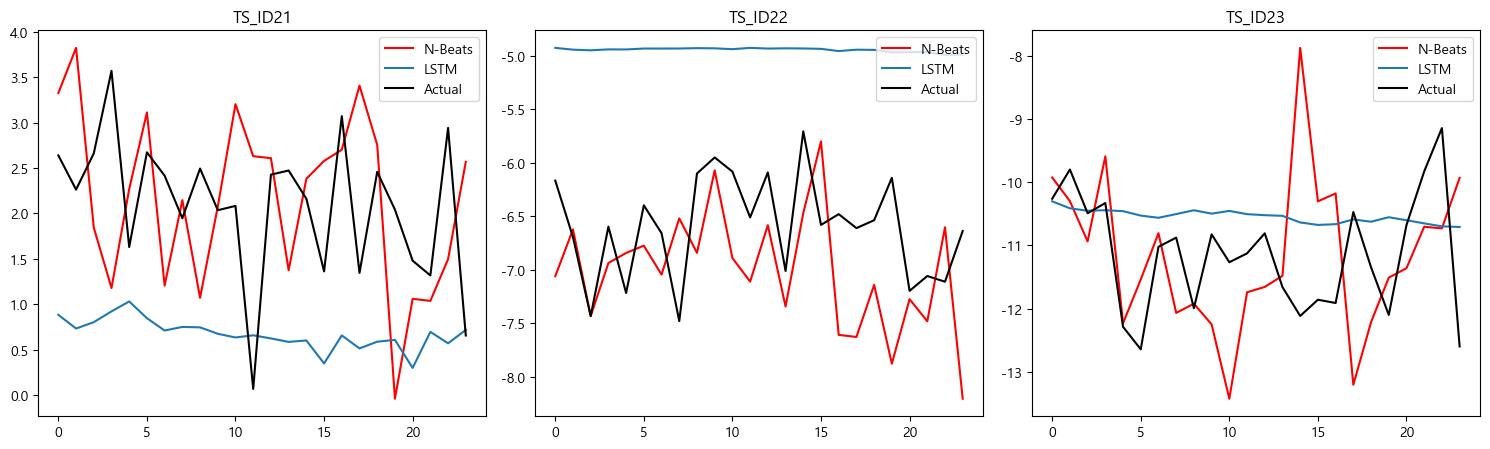

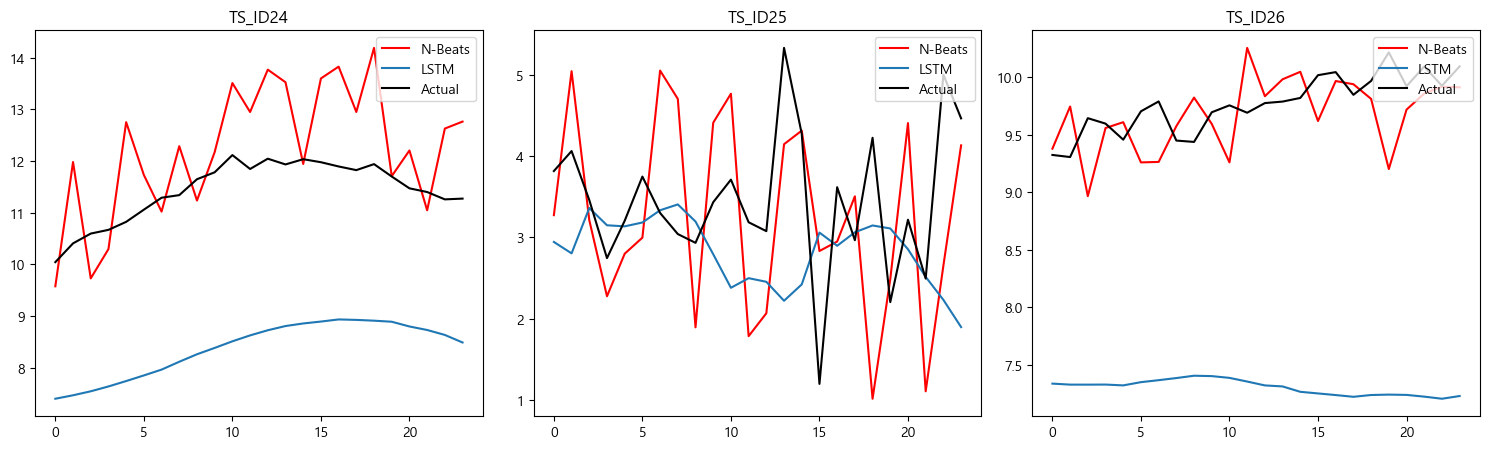

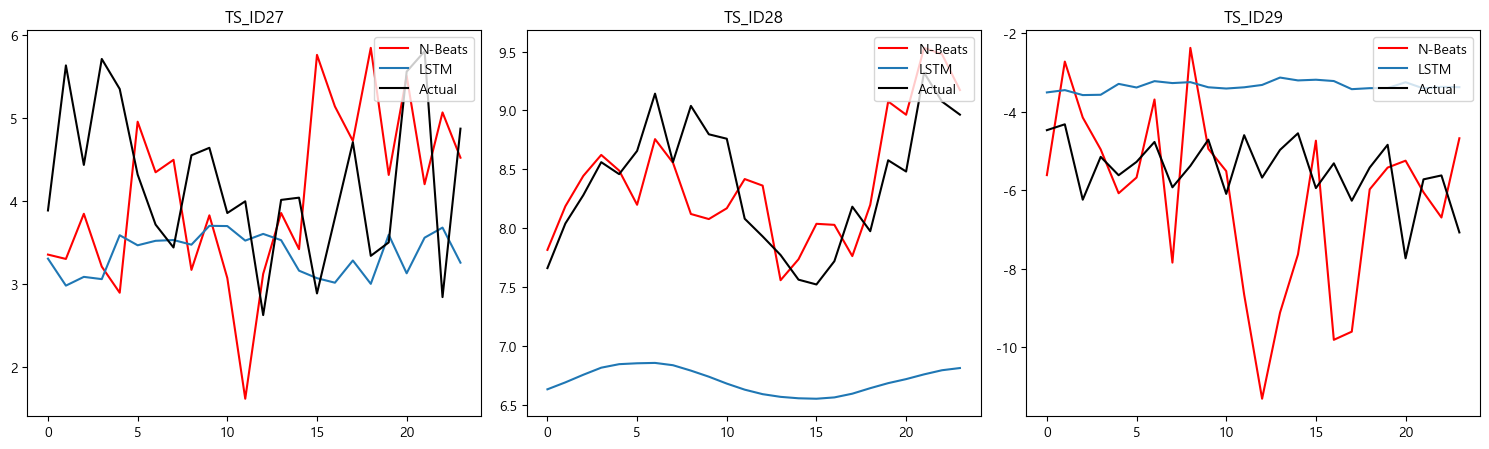

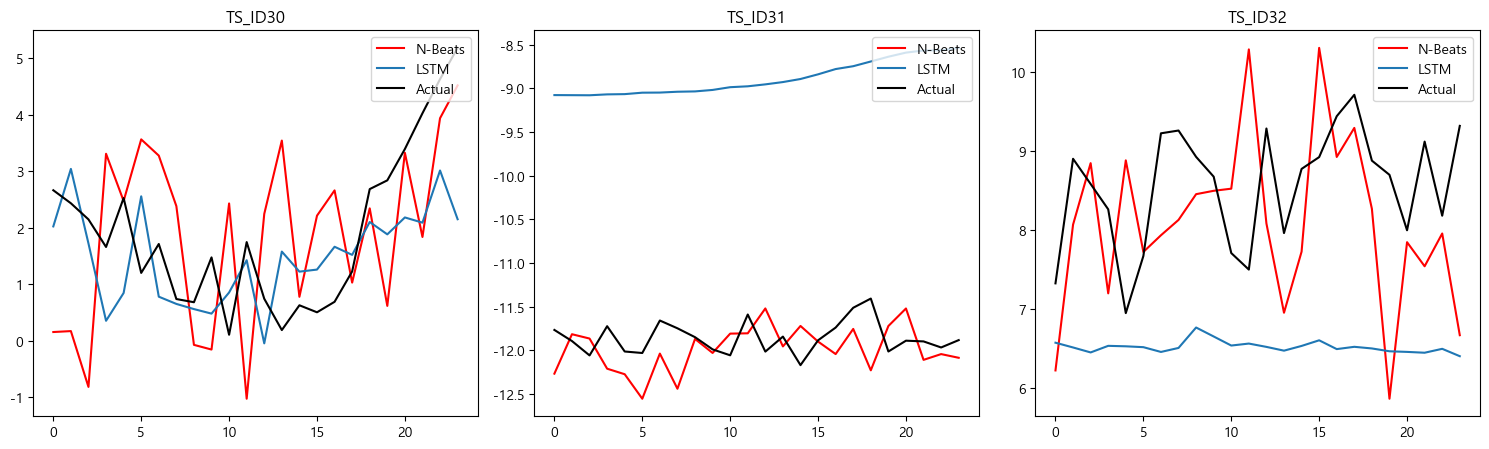

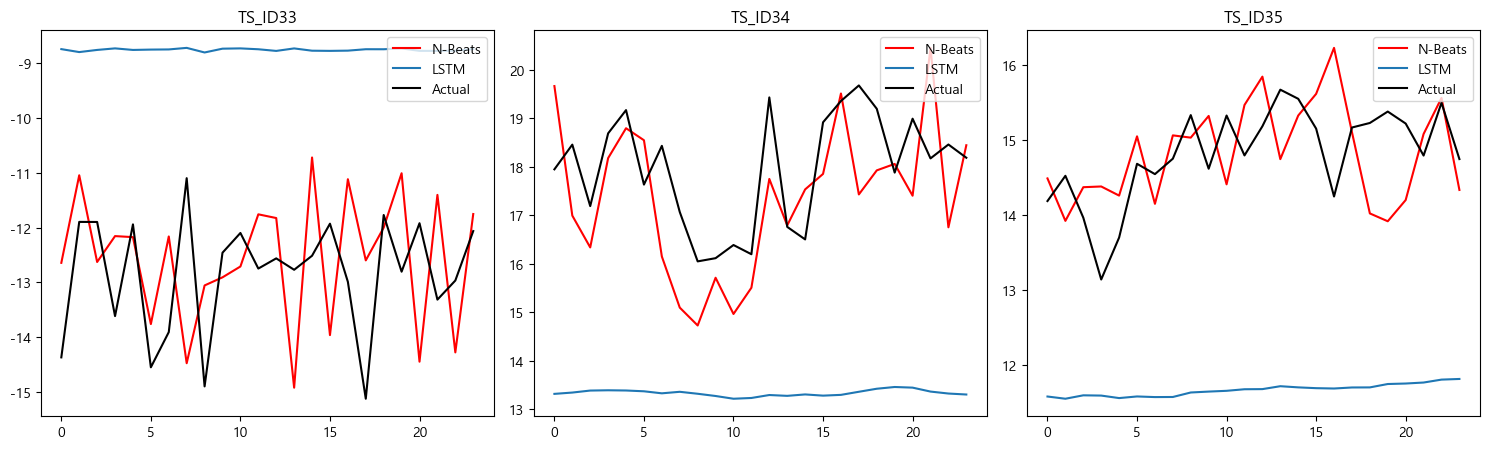

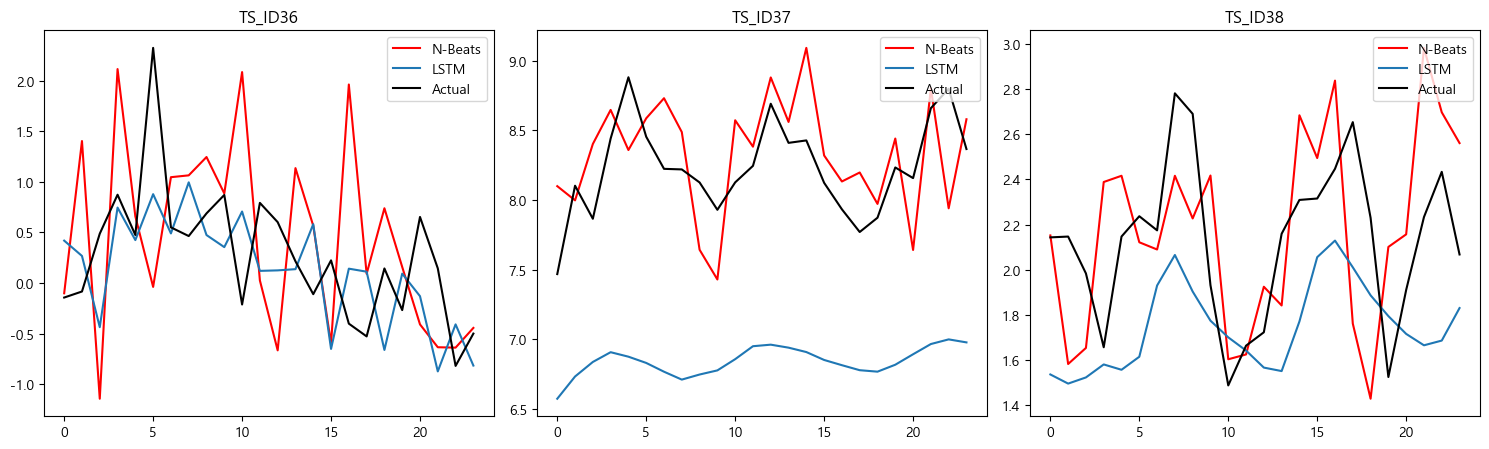

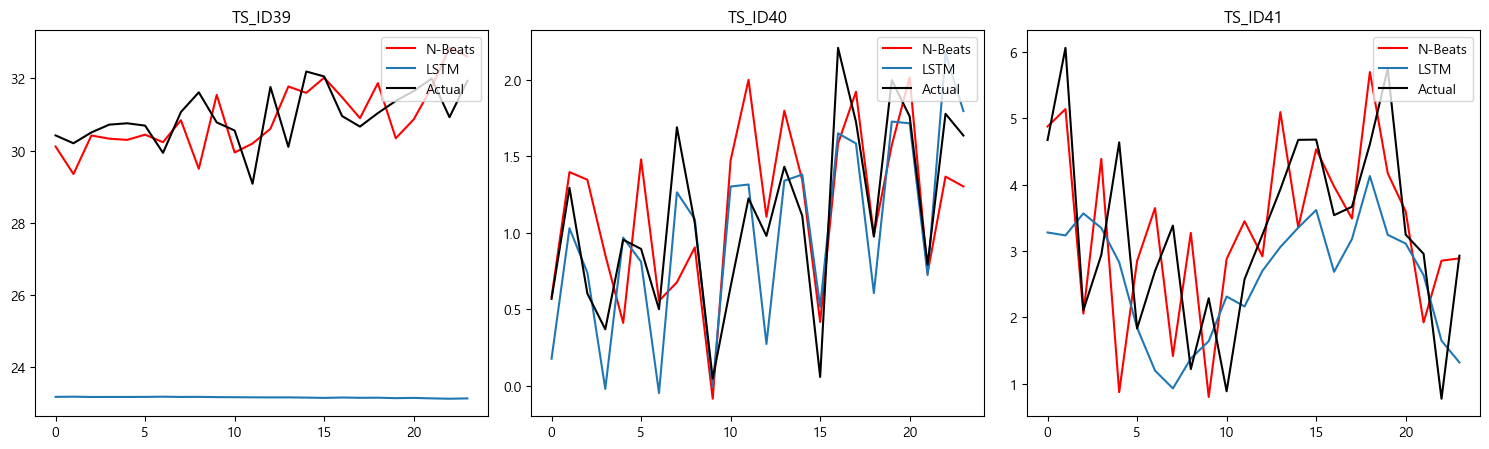

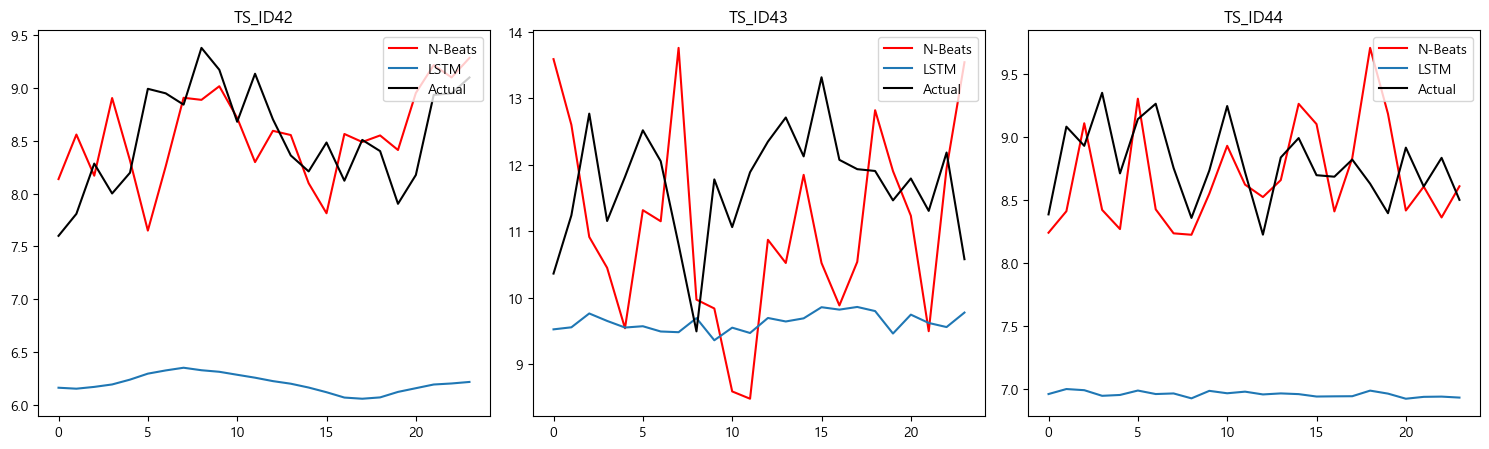

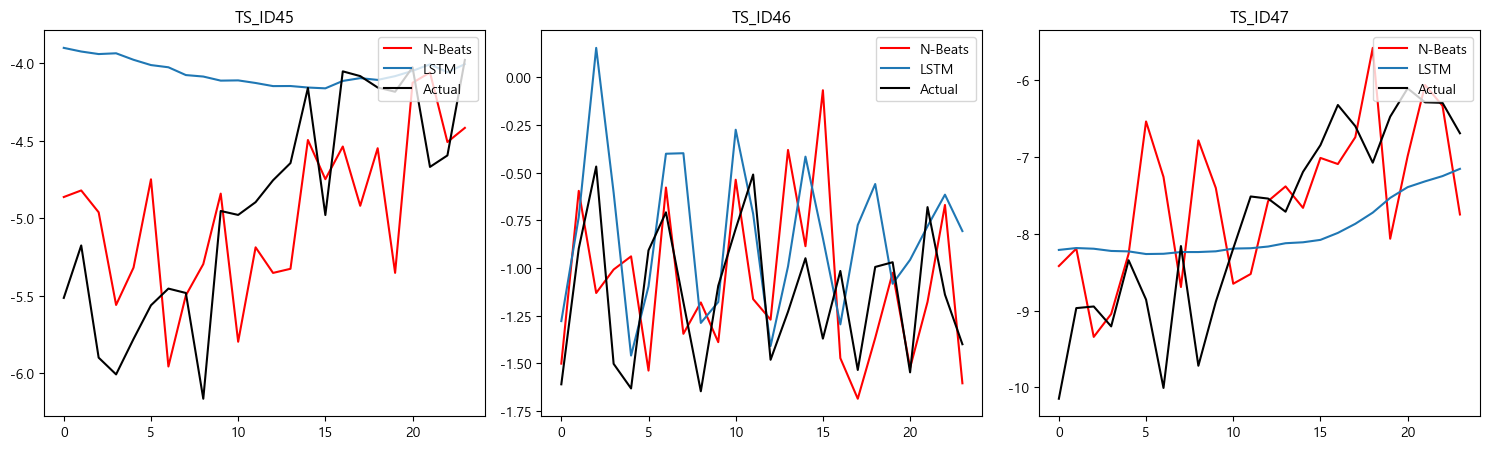

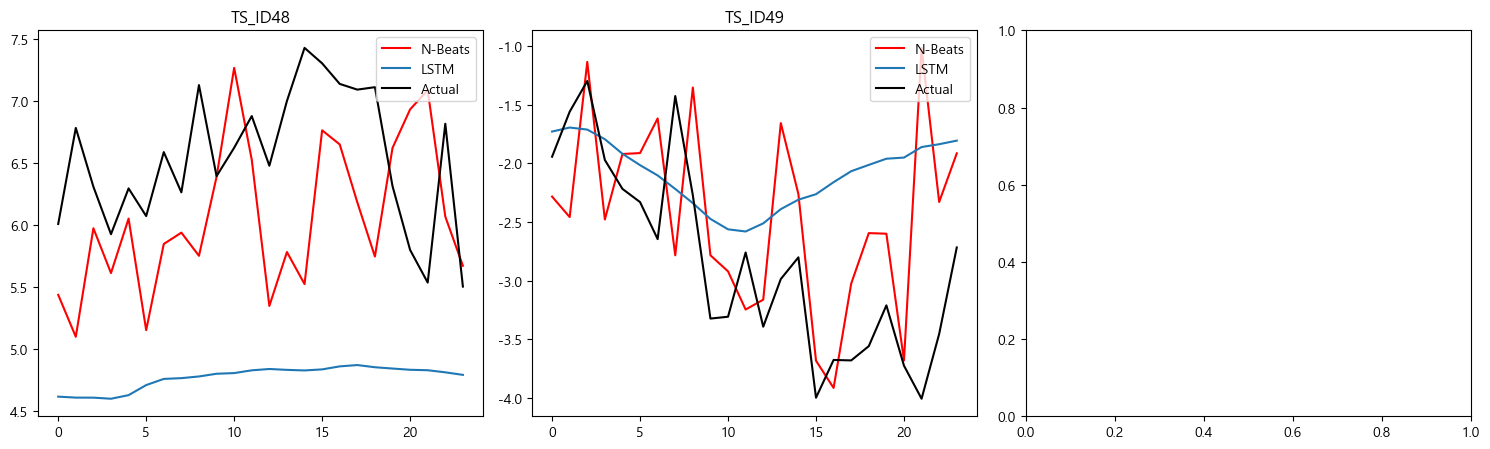

In [122]:
def plot_group(start_index):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1행 3열의 서브플롯 생성
    #fig.suptitle(f'Comparison of N-Beats, LSTM predictions, and Actual Data (Groups starting at index {start_index})')

    for i in range(3):
        index = start_index + i
        if index >TS_ID-1:
            break
        axs[i].plot(nbeats_pred_lst[index], label='N-Beats', color='red')
        axs[i].plot(lstm_pred_lst[index].flatten(), label='LSTM')
        axs[i].plot(y_test[index].flatten(), label='Actual', color='black')
        axs[i].legend(loc='upper right')
        axs[i].set_title(f'TS_ID{index}')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


for start_index in range(0, 50, 3):
    plot_group(start_index)

## mse, mae, mape

In [138]:
df_score= pd.concat([pd.DataFrame(nbeats_pred_score),pd.DataFrame(lstm_pred_score)],axis=1)
df_score.columns = ['nbeat mse','nbeat mae','nbeat mape','lstm mse','lstm mae','lstm mape']
df_score

,nbeat mse,nbeat mae,nbeat mape,lstm mse,lstm mae,lstm mape
0,0.950078,0.742663,0.064180,7.713741,2.740303,0.235188
1,0.007726,0.073988,0.303819,0.004265,0.055864,0.263782
2,0.160352,0.314241,0.328428,0.112944,0.265734,0.213418
3,2.282820,1.318545,13.908122,1.479005,0.984099,6.260976
4,0.265472,0.426441,0.080216,2.127496,1.403074,0.256332
5,0.092039,0.252493,0.035889,1.176492,1.071098,0.150843
6,0.781045,0.766045,0.331020,1.291118,0.989200,0.322005
7,0.365190,0.484720,0.112510,0.845018,0.795505,0.176834
8,0.967401,0.820040,0.168484,0.895806,0.806370,0.153168
9,0.907508,0.752071,0.075559,11.534132,3.279623,0.312504


## 각 지표 비교

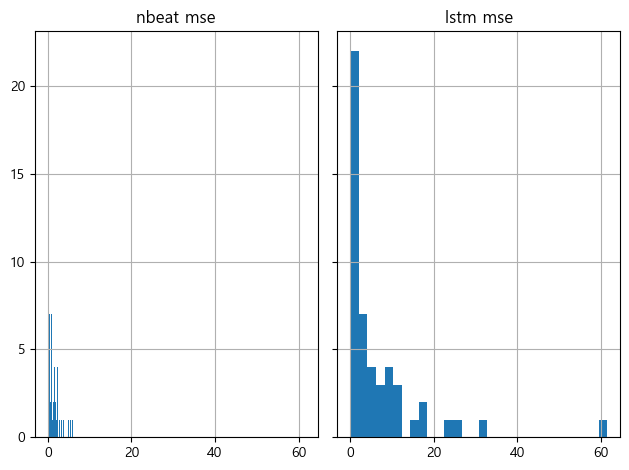

In [169]:
df_score.iloc[:,[0,3]].hist(bins=30,sharey=True, sharex = True, layout=(1, 2))
plt.tight_layout()
plt.show()

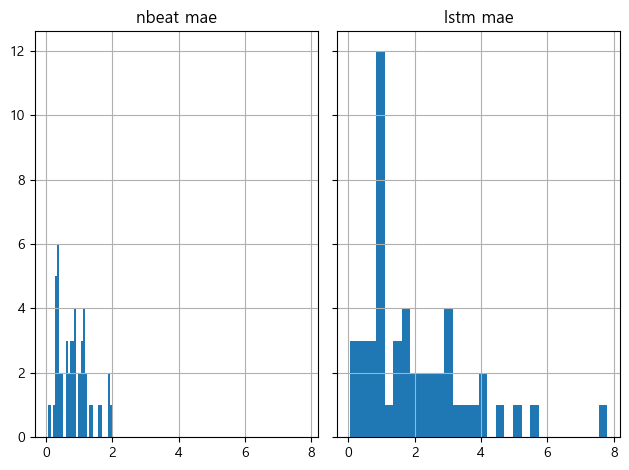

In [168]:
df_score.iloc[:,[1,4]].hist(bins=30,sharey=True, sharex = True, layout=(1, 2))
plt.tight_layout()
plt.show()

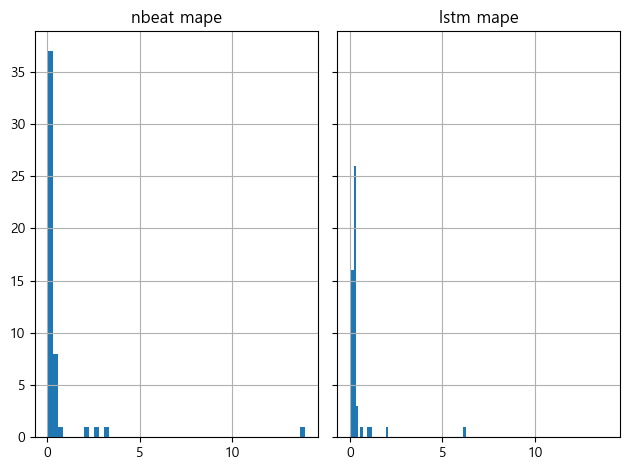

In [167]:
df_score.iloc[:,[2,5]].hist(bins=50,sharey=True, sharex = True, layout=(1, 2))
plt.tight_layout()
plt.show()

## 적합시간 히스토그램

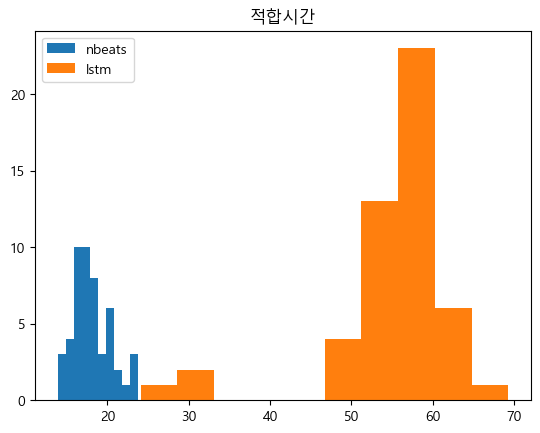

In [144]:

plt.hist(nbeats_pred_time, bins =10, label = 'nbeats')
plt.hist(lstm_pred_time, bins =10, label = 'lstm')
plt.title("적합시간")
plt.legend()
plt.show()